# Text preprocessing

In [1]:
DATA = "data/"
TRAIN = f"{DATA}/train.csv"
TEST = f"{DATA}/test.csv"
TRAIN_LABEL = f"{DATA}/train_label.txt"
TRAIN_TITLE = f"{DATA}/train_title.txt"
TRAIN_TEXT = f"{DATA}/train_text.txt"
TEST_LABEL = f"{DATA}/test_label.txt"
TEST_TITLE = f"{DATA}/test_title.txt"
TEST_TEXT = f"{DATA}/test_text.txt"

TRAIN_NORM = f"{DATA}/train_norm.txt"
TEST_NORM = f"{DATA}/test_norm.txt"

In [2]:
# # Splt the csv into label, title, text
# import pandas as pd

# train = pd.read_csv(TRAIN)
# train_col = train.columns
# train[train_col[0]].to_csv(TRAIN_LABEL, index=False)
# train[train_col[1]].to_csv(TRAIN_TITLE, index=False)
# train[train_col[2]].to_csv(TRAIN_TEXT, index=False)

# test = pd.read_csv(TEST)
# test_col = test.columns
# test[test_col[0]].to_csv(TEST_LABEL, index=False)
# test[test_col[1]].to_csv(TEST_TITLE, index=False)
# test[test_col[2]].to_csv(TEST_TEXT, index=False)
# del train, test, pd

In [3]:
# from src.Normalizer import normalize_data
# normalize_data(TRAIN_TEXT, TRAIN_NORM)
# normalize_data(TEST_TEXT, TEST_NORM)

# Training skipgram model

In [4]:
from src.SkipGram import SkipGram, Corpus, CorpusData
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

In [5]:
# Device Selection
if torch.backends.mps.is_available:
    device = "mps"  # OSX
elif torch.cuda.is_available:
    device = "cuda"
else:
    device = "cpu"

In [6]:
# Read The corpus, create all the training pairs
sk_corpus = Corpus(TRAIN_NORM, 2)
# Create a custom Dataset
sk_corpusdata = CorpusData(sk_corpus)
# Dataloader
sk_dataloader = DataLoader(sk_corpusdata, batch_size=4096, shuffle=True)

In [7]:
# Model definition
N = sk_corpus.vocab_size
H = 100  # Embeding dimension
model = SkipGram(N, H)
model = model.to(device)

In [8]:
model, log = model.train_model(sk_dataloader, 5, 1e-3, device)

Epoch 1/5: 100%|██████████| 808/808 [02:55<00:00,  4.61it/s, loss=10.62]


# Text Classifiers

In [9]:
# import src.TextClassifier as TCl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import numpy as np

class TextClassifier(nn.Module):
    def __init__(self, nbrclass, embedding, train_embeddings=False) -> None:
        super(TextClassifier, self).__init__()
        self.embedding = self.__embedding(embedding, train_embeddings)
        self.classifier = nn.Sequential(
            nn.Linear(self.embedding.embedding_dim, 512), nn.Linear(512, nbrclass)
        )

    def forward(self, x):
        x = self.mean_embedding(x)
        return self.classifier(x)

    def __embedding(self, embedding, train_embeddings):
        embedding.requires_grad = train_embeddings
        return embedding

    def mean_embedding(self, x):
        x = self.embedding(x)
        x = torch.mean(x, dim=1)
        return x

    def train_classifier(self, dataloader, num_epochs, lr, device):
        optimizer = optim.NAdam(self.parameters(), lr)
        criterion = nn.CrossEntropyLoss()
        N = len(dataloader.dataset)
        log = []
        self.train()
        for epoch in range(num_epochs):
            total_loss = 0
            correct = 0
            pbar = tqdm(dataloader, total=len(dataloader), desc=f"Epoch {epoch+1}")
            for x, y in pbar:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                output = self(x)
                loss = criterion(output, y)
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * x.size(0)

                # Calculate accuracy
                _, predicted = torch.max(output, 1)
                correct += (predicted == y).sum().item()

                pbar.set_postfix(
                    loss=f"{total_loss/N:.2f}", accuracy=f"{correct/N:.2f}"
                )

            avg_loss = total_loss / N
            accuracy = correct / N
            log.append((avg_loss, accuracy))

        self.eval()
        return self, log


class CorpusClassifier:
    def __init__(self, text, label, mapping):
        self.x_file = text
        self.y_file = label
        self.x = []
        self.y = []
        self.word2id = mapping
        self.__read_data()

    def __read_data(self):
        with open(self.y_file) as f:
            for y in f:
                self.y.append(int(y.strip()))

        with open(self.x_file) as file:
            for line in file:
                line = line.strip().split()
                text = [self.word2id[word] for word in line]
                self.x.append(text)


class ClassifierData(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx):
        x = torch.tensor(self.data.x[idx], dtype=torch.long)
        y = torch.tensor(self.data.y[idx], dtype=torch.long)
        return x, y

    def __len__(self):
        return len(self.data.y)


def collate_fn(batch):
    # Separate the inputs and targets
    input_, targets = zip(*batch)
    # Pad sequences
    input_ = pad_sequence(input_, batch_first=True, padding_value=0)
    # Stack targets
    targets = torch.stack(targets)
    return input_, targets


def dataLoader(dataset, batch_size):
    return DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)


In [10]:
word2id = sk_corpus.word2id
texts = CorpusClassifier(
    f"{DATA}/train_norm.txt", f"{DATA}/test_label.txt", word2id
)
textsdata = ClassifierData(texts)
textsloader = dataLoader(textsdata, 4096)

In [11]:
embedding = model.vEmbedding
classf = TextClassifier(4, embedding, False)
classf = classf.to(device)

In [12]:
classf, log = classf.train_classifier(textsloader, 200, 1e-5, device)

Epoch 200: 100%|██████████| 2/2 [00:00<00:00, 18.22it/s, accuracy=0.25, loss=0.85]


In [13]:
log = np.array(log)

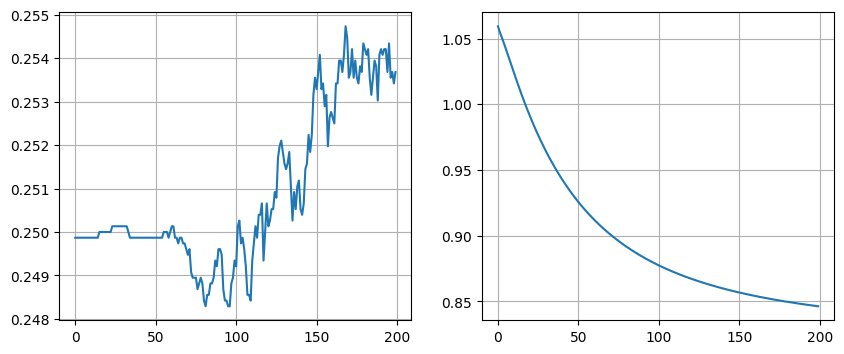

In [14]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(log[:, 1])
plt.grid()
plt.subplot(122)
plt.plot(log[:, 0])
plt.grid()
plt.show()